In [1]:
from astropy.coordinates import match_coordinates_sky
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib
from matplotlib import gridspec as gridspec, lines as mlines, pyplot as plt
from matplotlib import patches
import numpy as np
import pandas as pd

SELECT ALL
source_id,ra,ra_error,dec,dec_error,
pmra, pmra_error, pmdec, pmdec_error,
parallax,parallax_error,phot_g_mean_mag,bp_rp,
radial_velocity,radial_velocity_error,
phot_variable_flag,teff_val,a_g_val

FROM gaiadr2.gaia_source

WHERE
CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),
CIRCLE('ICRS',187.70593075,12.391123311,2))=1

In [2]:
def grids():
    ax.minorticks_on()
    ax.tick_params('both', length=8, which='major', labelsize='10')
    ax.tick_params('both',length=3, which='minor')
    ax.set_axisbelow(True)
    ax.grid(True, which='major', ls='dashed', alpha=.5, zorder=0)
    ax.grid(True, which='minor', ls='dashed', alpha=.15, zorder=0)

In [3]:
mmt_df = pd.read_csv('toaaron_jul17_c.txt0')
mmt_df['gmag'] = mmt_df['gi'] + mmt_df['i0_OA']

In [4]:
gaia_df = pd.read_csv('m87big-result.csv')
gaia_df['pm'] = np.sqrt(gaia_df['pmra']**2+gaia_df['pmdec']**2)
gaia_df['pm_error'] = np.sqrt(gaia_df['pmra_error']**2+gaia_df['pmdec_error']**2)
gaia_df['motion'] = np.sqrt((gaia_df['pmra']/gaia_df['pmra_error'])**2 +
                            (gaia_df['pmdec']/gaia_df['pmdec_error'])**2 +
                            (gaia_df['parallax']/gaia_df['parallax_error'])**2) / np.sqrt(3)

In [5]:
gaia_coords = SkyCoord(ra=list(gaia_df.ra) * u.degree,
                       dec=list(gaia_df.dec) * u.degree)
mmt_coords = SkyCoord(ra=list(mmt_df.RA) * u.degree,
                      dec=list(mmt_df.Dec) * u.degree)

In [6]:
idx_gaia_matches, idx_mmt_matches, d2d, d3d = mmt_coords.search_around_sky(gaia_coords, 0.6*u.arcsec)

In [7]:
match_df = pd.concat([mmt_df.iloc[idx_mmt_matches].reset_index(),
                      gaia_df.iloc[idx_gaia_matches].reset_index()],
                     axis=1)
match_df.head()

,index,ID,RA,Dec,fRV,err_RV,nsrc,cl,Kocls,i0_OA,...,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val,pm,pm_error,motion
0,2224,SC135,188.761963,11.574129,129,13,S17,star,NaN,19.311,...,19.738651,1.165604,NaN,NaN,NOT_AVAILABLE,NaN,NaN,19.643906,1.563439,8.333182
1,262,SC120,188.388546,11.528264,990,14,S17,GC,NaN,19.271,...,19.994360,0.959484,NaN,NaN,NOT_AVAILABLE,NaN,NaN,4.217858,3.220163,1.140332
2,2164,SC376,188.199850,11.654059,167,13,S17,star,NaN,20.276,...,20.653421,0.632269,NaN,NaN,NOT_AVAILABLE,NaN,NaN,6.501949,4.739692,1.130646
3,2161,SC29,188.112808,11.621061,-39,12,S17,star,NaN,18.630,...,19.041458,1.174898,NaN,NaN,NOT_AVAILABLE,NaN,NaN,27.223648,0.977027,30.105076
4,2186,SC35,188.344667,11.532853,43,12,S17,star,NaN,18.701,...,19.114847,1.166815,NaN,NaN,NOT_AVAILABLE,NaN,NaN,8.604168,1.029931,6.148863


In [8]:
data_ra_dec_only = match_df[['ID', 'RA', 'Dec']]

np.savetxt(fname=r'mmt_gaia_match_ra_dec.txt', X=data_ra_dec_only,
           fmt=('%s', '%f', '%f'),
           header=r'source_id, ra, dec',
           comments='')

## Plotting sources around M87

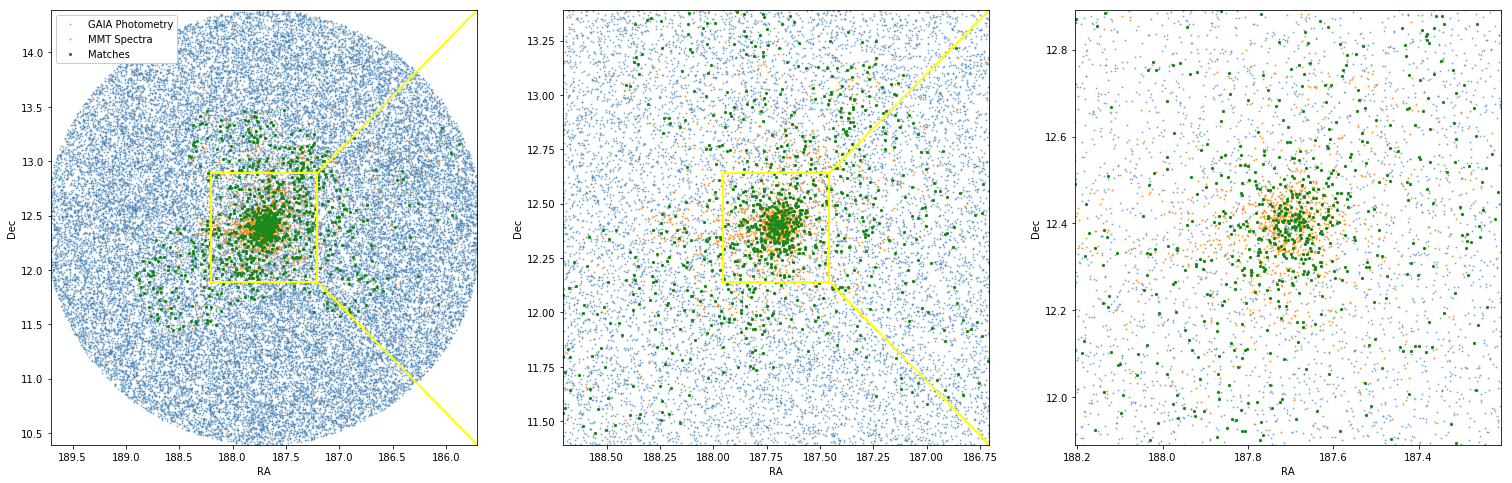

In [9]:
height_ratios = [8]
width_ratios = [8, 8, 8]
wspace, hspace = 1, 0
m87_ra, m87_dec = 187.70593075, 12.391123311
plot_lim_0, plot_lim_1, plot_lim_2 = 2, 1, .5

fig = plt.figure(figsize=(sum(width_ratios) + wspace * (len(width_ratios) - 1),
                          sum(height_ratios) + hspace * (len(height_ratios) - 1)))
gs = gridspec.GridSpec(len(height_ratios), len(width_ratios),
                       height_ratios=height_ratios, width_ratios=width_ratios)

# First zoom on M87
ax = fig.add_subplot(gs[0])
gaia_df.plot(x='ra', y='dec', kind='scatter',
             s=1, alpha=.5, marker='o', c='SteelBlue',
             label='GAIA Photometry', ax=ax)
mmt_df.plot(x='RA', y='Dec', kind='scatter',
            s=1, alpha=.75, marker='o', c='DarkOrange',
            label='MMT Spectra', ax=ax)
match_df.plot(x='RA', y='Dec', kind='scatter',
              s=5, alpha=1, marker='o', c='Green',
              edgecolors='ForestGreen', label='Matches', ax=ax)
box = patches.Rectangle((m87_ra-plot_lim_1/2., m87_dec-plot_lim_1/2.),
                        plot_lim_1, plot_lim_1, linewidth=2,
                        edgecolor='yellow', fill=False)
ax.add_patch(box)
plt.plot(np.linspace(m87_ra-plot_lim_1/2., m87_ra-plot_lim_0, 100),
         np.linspace(m87_dec+plot_lim_1/2., m87_dec+plot_lim_0, 100),
         color='yellow', linestyle='solid', lw=2)
plt.plot(np.linspace(m87_ra-plot_lim_1/2., m87_ra-plot_lim_0, 100),
         np.linspace(m87_dec-plot_lim_1/2., m87_dec-plot_lim_0, 100),
         color='yellow', linestyle='solid', lw=2)
ax.set_xlim(m87_ra+plot_lim_0,m87_ra-plot_lim_0)
ax.set_ylim(m87_dec-plot_lim_0,m87_dec+plot_lim_0)
ax.legend(framealpha=1)

# Second zoom on M87
ax = fig.add_subplot(gs[1])
gaia_df.plot(x='ra', y='dec', kind='scatter',
             s=1, alpha=.5, marker='o', c='SteelBlue',
             label='GAIA Photometry', ax=ax)
mmt_df.plot(x='RA', y='Dec', kind='scatter',
            s=1, alpha=.75, marker='o', c='DarkOrange',
            label='MMT Spectra', ax=ax)
match_df.plot(x='RA', y='Dec', kind='scatter',
              s=5, alpha=1, marker='o', c='Green',
              edgecolors='ForestGreen', label='Matches', ax=ax)
box = patches.Rectangle((m87_ra-plot_lim_2/2., m87_dec-plot_lim_2/2.),
                        plot_lim_2, plot_lim_2, linewidth=2,
                        edgecolor='yellow', fill=False)
ax.add_patch(box)
plt.plot(np.linspace(m87_ra-plot_lim_2/2., m87_ra-plot_lim_1, 100),
         np.linspace(m87_dec+plot_lim_2/2., m87_dec+plot_lim_1, 100),
         color='yellow', linestyle='solid', lw=2)
plt.plot(np.linspace(m87_ra-plot_lim_2/2., m87_ra-plot_lim_1, 100),
         np.linspace(m87_dec-plot_lim_2/2., m87_dec-plot_lim_1, 100),
         color='yellow', linestyle='solid', lw=2)
ax.set_xlim(m87_ra+plot_lim_1,m87_ra-plot_lim_1)
ax.set_ylim(m87_dec-plot_lim_1,m87_dec+plot_lim_1)
ax.legend_.remove()

# Third zoom on M87
ax = fig.add_subplot(gs[2])
gaia_df.plot(x='ra', y='dec', kind='scatter',
             s=1, alpha=.5, marker='o', c='SteelBlue',
             label='GAIA Photometry', ax=ax)
mmt_df.plot(x='RA', y='Dec', kind='scatter',
            s=1, alpha=.75, marker='o', c='DarkOrange',
            label='MMT Spectra', ax=ax)
match_df.plot(x='RA', y='Dec', kind='scatter',
              s=5, alpha=1, marker='o', c='Green',
              edgecolors='ForestGreen', label='Matches', ax=ax)
ax.set_xlim(m87_ra+plot_lim_2,m87_ra-plot_lim_2)
ax.set_ylim(m87_dec-plot_lim_2,m87_dec+plot_lim_2)
ax.legend_.remove()

plt.savefig('m87.png', dpi=300)
plt.show()

## Color Magnitudes

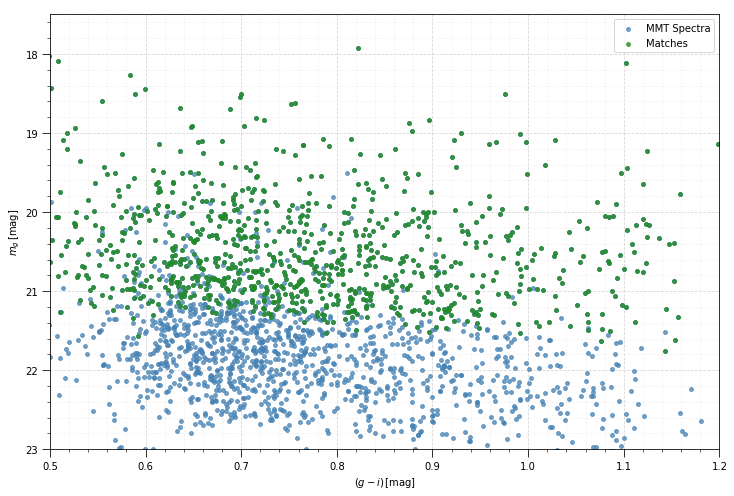

In [16]:
ax = mmt_df.plot(x='gi', y='gmag', kind='scatter',
                  s=15, alpha=.75, marker='o', c='SteelBlue',
                  label='MMT Spectra', figsize=(12,8))
match_df.plot(x='gi', y='gmag', kind='scatter',
              s=15, alpha=.75, marker='o', c='ForestGreen',
              label='Matches', ax=ax)
ax.set_xlim(0.5,1.2)
ax.set_ylim(23,17.5)
ax.set_xlabel('$(g-i) \, \mathrm{[mag]}$')
ax.set_ylabel('$m_g \, \mathrm{[mag]}$')
ax.legend(loc='best')
grids()
plt.savefig('m87mgvgi.png', dpi=300)
plt.show()

## Parallax vs Velocity

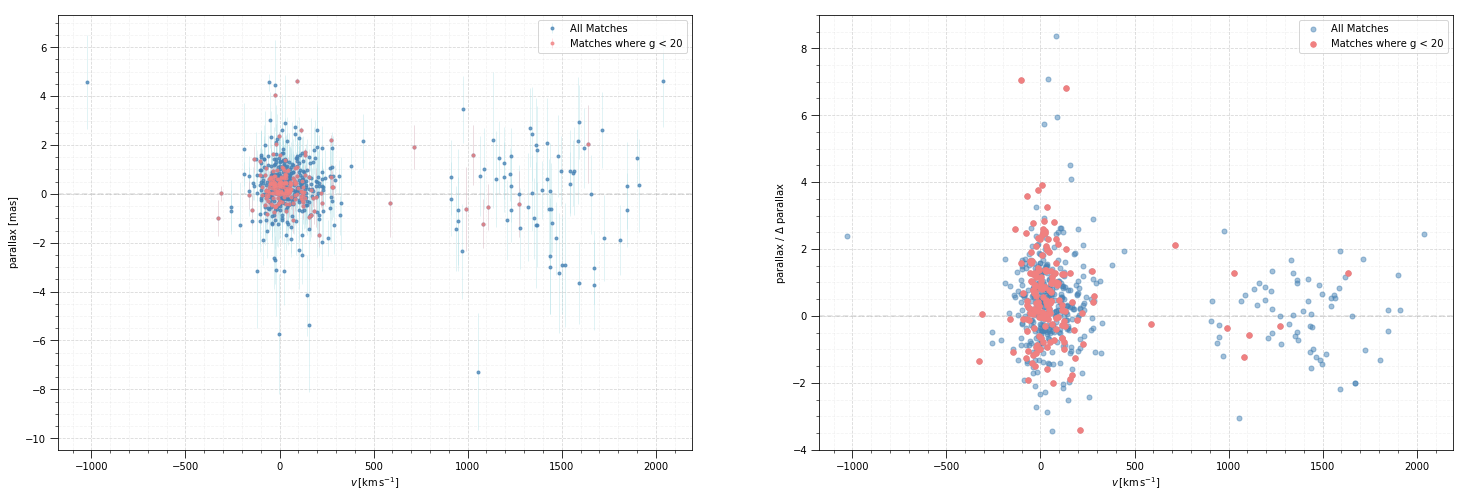

In [22]:
height_ratios = [8]
width_ratios = [12, 12]
wspace, hspace = 1, 0
fig = plt.figure(figsize=(sum(width_ratios) + wspace * (len(width_ratios) - 1),
                          sum(height_ratios) + hspace * (len(height_ratios) - 1)))
gs = gridspec.GridSpec(len(height_ratios), len(width_ratios),
                       height_ratios=height_ratios, width_ratios=width_ratios)

ax = fig.add_subplot(gs[0])
ax.errorbar(match_df['fRV'], match_df['parallax'],
            yerr=match_df['parallax_error'], ls='none',
            ecolor='powderblue', elinewidth=.5,
            alpha=.75, ms=3, marker='o', c='steelblue',
            label='All Matches')
ax.errorbar(match_df['fRV'][match_df['gmag']<20],
            match_df['parallax'][match_df['gmag']<20],
            yerr=match_df['parallax_error'][match_df['gmag']<20], ls='none',
            ecolor='lightpink', elinewidth=.5,
            alpha=.75, ms=3, marker='o', c='lightcoral',
            label='Matches where g < 20')
ax.axhline(y=0, c='lightgrey', linestyle='dashed', alpha=.75,zorder=0)
ax.set_xlabel('$v \, \mathrm{[km\,s^{-1}]}$')
ax.set_ylabel('parallax $\mathrm{[mas]}$')
ax.legend(loc='best')
grids()

ax = fig.add_subplot(gs[1])
ax.scatter(match_df['fRV'], match_df['parallax']/match_df['parallax_error'],
           alpha=.5, s=25, marker='o', c='steelblue',
           label='All Matches')
ax.scatter(match_df['fRV'][match_df['gmag']<20],
            match_df['parallax'][match_df['gmag']<20]/match_df['parallax_error'][match_df['gmag']<20],
            alpha=1, s=30, marker='o', c='lightcoral',
           label='Matches where g < 20')
ax.axhline(y=0, c='lightgrey', linestyle='dashed', alpha=.75,zorder=0)
ax.set_xlabel('$v \, \mathrm{[km\,s^{-1}]}$')
ax.set_ylabel('parallax / $\Delta$ parallax')
ax.set_ylim(-4,9)
ax.legend(loc='best')
grids()

plt.savefig('m87parallaxvv.png', dpi=300)
plt.show()

## Proper Motion vs Velocity

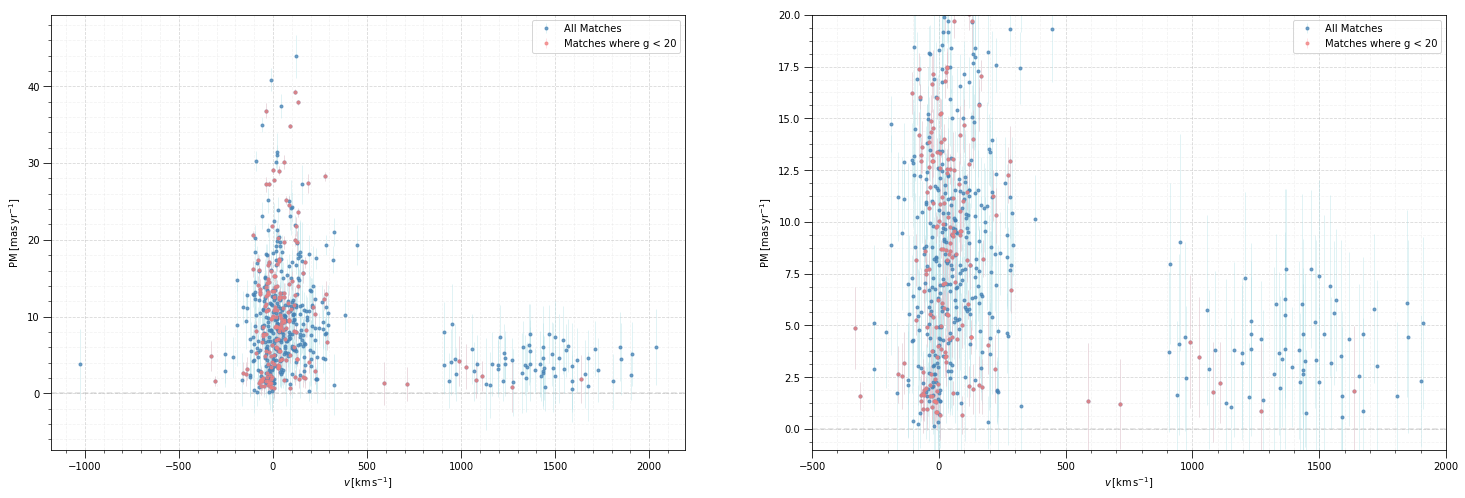

In [23]:
height_ratios = [8]
width_ratios = [12, 12]
wspace, hspace = 1, 0
fig = plt.figure(figsize=(sum(width_ratios) + wspace * (len(width_ratios) - 1),
                          sum(height_ratios) + hspace * (len(height_ratios) - 1)))
gs = gridspec.GridSpec(len(height_ratios), len(width_ratios),
                       height_ratios=height_ratios, width_ratios=width_ratios)

ax = fig.add_subplot(gs[0])
ax.errorbar(match_df['fRV'], match_df['pm'],
            yerr=match_df['pm_error'], ls='none',
            ecolor='powderblue', elinewidth=.5,
            alpha=.75, ms=3, marker='o', c='steelblue',
            label='All Matches')
ax.errorbar(match_df['fRV'][match_df['gmag']<20],
            match_df['pm'][match_df['gmag']<20],
            yerr=match_df['pm_error'][match_df['gmag']<20], ls='none',
            ecolor='lightpink', elinewidth=.5,
            alpha=.75, ms=3, marker='o', c='lightcoral',
            label='Matches where g < 20')
ax.axhline(y=0, c='lightgrey', linestyle='dashed', alpha=.75,zorder=0)
ax.set_xlabel('$v \, \mathrm{[km\,s^{-1}]}$')
ax.set_ylabel('PM $\mathrm{[mas\,yr^{-1}]}$')
ax.legend(loc='best')
grids()

ax = fig.add_subplot(gs[1])
ax.errorbar(match_df['fRV'], match_df['pm'],
            yerr=match_df['pm_error'], ls='none',
            ecolor='powderblue', elinewidth=.5,
            alpha=.75, ms=3, marker='o', c='steelblue',
            label='All Matches')
ax.errorbar(match_df['fRV'][match_df['gmag']<20],
            match_df['pm'][match_df['gmag']<20],
            yerr=match_df['pm_error'][match_df['gmag']<20], ls='none',
            ecolor='lightpink', elinewidth=.5,
            alpha=.75, ms=3, marker='o', c='lightcoral',
            label='Matches where g < 20')
ax.axhline(y=0, c='lightgrey', linestyle='dashed', alpha=.75,zorder=0)
ax.set_xlabel('$v \, \mathrm{[km\,s^{-1}]}$')
ax.set_ylabel('PM $\mathrm{[mas\,yr^{-1}]}$')
ax.set_xlim(-500,2000)
ax.set_ylim(-1,20)
ax.legend(loc='best')
grids()

plt.savefig('m87pmvv.png', dpi=300)
plt.show()

## Proper Motion Sigma vs Velocity

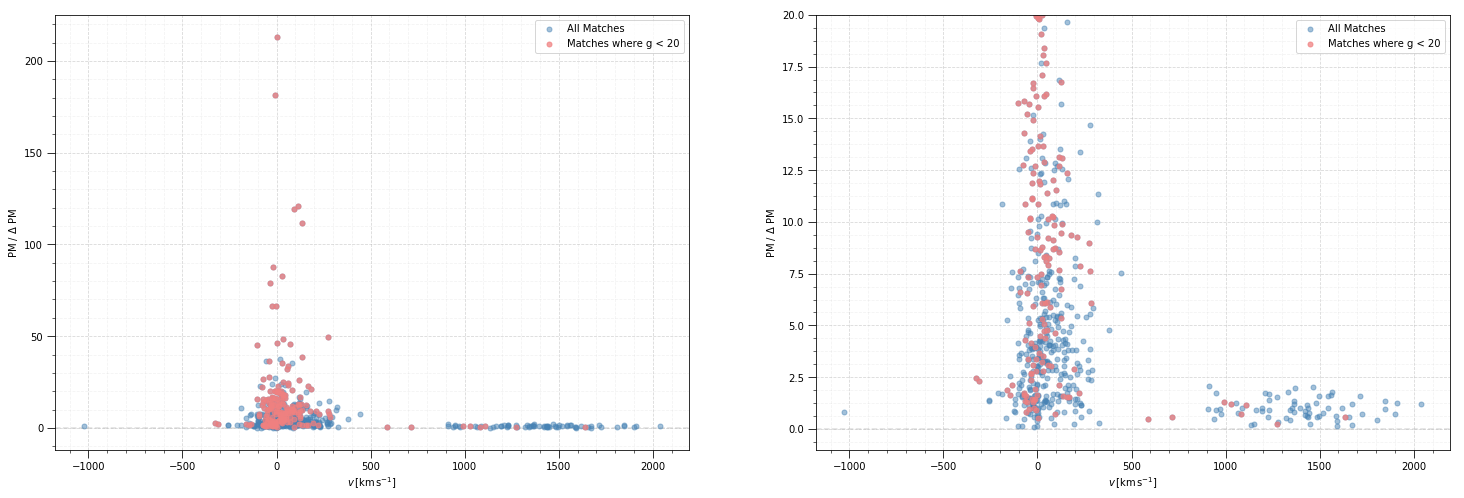

In [28]:
height_ratios = [8]
width_ratios = [12, 12]
wspace, hspace = 1, 0
fig = plt.figure(figsize=(sum(width_ratios) + wspace * (len(width_ratios) - 1),
                          sum(height_ratios) + hspace * (len(height_ratios) - 1)))
gs = gridspec.GridSpec(len(height_ratios), len(width_ratios),
                       height_ratios=height_ratios, width_ratios=width_ratios)

ax = fig.add_subplot(gs[0])
ax.scatter(match_df['fRV'], match_df['pm']/match_df['pm_error'],
           alpha=.5, s=25, marker='o', c='steelblue',
           label='All Matches')
ax.scatter(match_df['fRV'][match_df['gmag']<20],
           match_df['pm'][match_df['gmag']<20]/match_df['pm_error'][match_df['gmag']<20],
           alpha=.75, s=25, marker='o', c='lightcoral',
           label='Matches where g < 20')
ax.axhline(y=0, c='lightgrey', linestyle='dashed', alpha=.75,zorder=0)
ax.set_xlabel('$v \, \mathrm{[km\,s^{-1}]}$')
ax.set_ylabel('PM / $\Delta$ PM')
ax.legend(loc='best')
grids()

ax = fig.add_subplot(gs[1])
ax.scatter(match_df['fRV'], match_df['pm']/match_df['pm_error'],
           alpha=.5, s=25, marker='o', c='steelblue',
           label='All Matches')
ax.scatter(match_df['fRV'][match_df['gmag']<20],
           match_df['pm'][match_df['gmag']<20]/match_df['pm_error'][match_df['gmag']<20],
           alpha=.75, s=25, marker='o', c='lightcoral',
           label='Matches where g < 20')
ax.axhline(y=0, c='lightgrey', linestyle='dashed', alpha=.75,zorder=0)
ax.set_xlabel('$v \, \mathrm{[km\,s^{-1}]}$')
ax.set_ylabel('PM / $\Delta$ PM')
ax.set_ylim(-1,20)
ax.legend(loc='best')
grids()

plt.show()

## Proper Motion Sigma vs G Magnitude

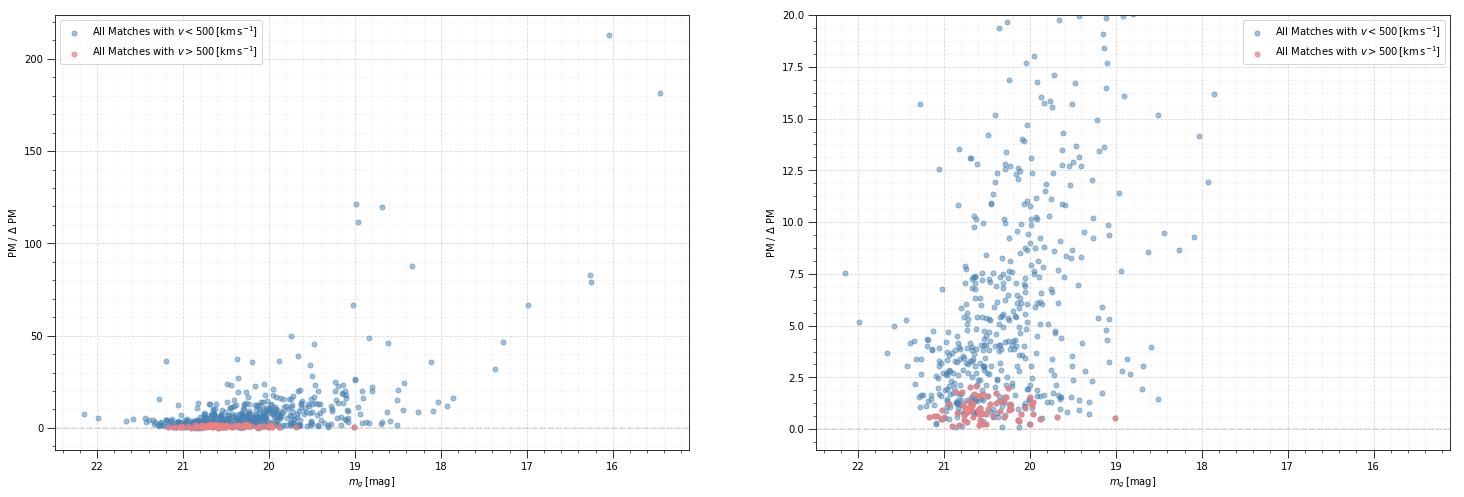

In [27]:
height_ratios = [8]
width_ratios = [12, 12]
wspace, hspace = 1, 0
fig = plt.figure(figsize=(sum(width_ratios) + wspace * (len(width_ratios) - 1),
                          sum(height_ratios) + hspace * (len(height_ratios) - 1)))
gs = gridspec.GridSpec(len(height_ratios), len(width_ratios),
                       height_ratios=height_ratios, width_ratios=width_ratios)

ax = fig.add_subplot(gs[0])
ax.scatter(match_df['gmag'], match_df['pm']/match_df['pm_error'],
           alpha=.5, s=25, marker='o', c='steelblue',
           label='All Matches with $v < 500 \, \mathrm{[km\,s^{-1}]}$')
ax.scatter(match_df['gmag'][match_df['fRV']>500],
           match_df['pm'][match_df['fRV']>500]/match_df['pm_error'][match_df['fRV']>500],
           alpha=.75, s=25, marker='o', c='lightcoral',
           label='All Matches with $v > 500 \, \mathrm{[km\,s^{-1}]}$')
ax.axhline(y=0, c='lightgrey', linestyle='dashed', alpha=.75,zorder=0)
ax.invert_xaxis()
ax.set_xlabel('$m_g \, \mathrm{[mag]}$')
ax.set_ylabel('PM / $\Delta$ PM')
ax.legend(loc='best')
grids()

ax = fig.add_subplot(gs[1])
ax.scatter(match_df['gmag'], match_df['pm']/match_df['pm_error'],
           alpha=.5, s=25, marker='o', c='steelblue',
           label='All Matches with $v < 500 \, \mathrm{[km\,s^{-1}]}$')
ax.scatter(match_df['gmag'][match_df['fRV']>500],
           match_df['pm'][match_df['fRV']>500]/match_df['pm_error'][match_df['fRV']>500],
           alpha=.75, s=25, marker='o', c='lightcoral',
           label='All Matches with $v > 500 \, \mathrm{[km\,s^{-1}]}$')
ax.axhline(y=0, c='lightgrey', linestyle='dashed', alpha=.75,zorder=0)
ax.invert_xaxis()
ax.set_xlabel('$m_g \, \mathrm{[mag]}$')
ax.set_ylabel('PM / $\Delta$ PM')
ax.set_ylim(-1,20)
ax.legend(loc='best')
grids()

plt.show()